### DATASETS & DATALOADERS

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets

### Loading a Dataset

Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:

 - root is the path where the train/test data is stored,
 - train specifies training or test dataset,
 - download=True downloads the data from the internet if it’s not available at root.
 - transform and target_transform specify the feature and label transformations.

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO. In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



### Iterating and Visualizing the Dataset

We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

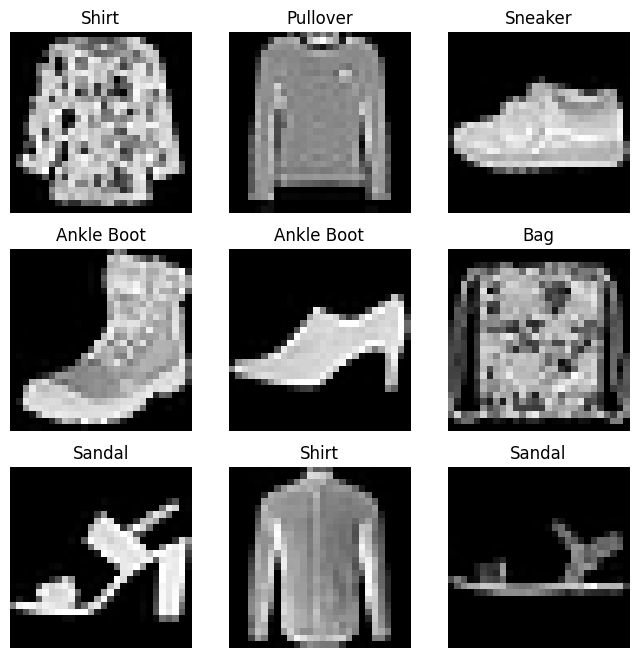

In [16]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating Models

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters

To train a model, we need a loss function and an optimizer.

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297455  [   64/60000]
loss: 2.285626  [ 6464/60000]
loss: 2.265069  [12864/60000]
loss: 2.265851  [19264/60000]
loss: 2.250364  [25664/60000]
loss: 2.216754  [32064/60000]
loss: 2.228541  [38464/60000]
loss: 2.195403  [44864/60000]
loss: 2.186396  [51264/60000]
loss: 2.165175  [57664/60000]
Test Error: 
 Accuracy: 41.4%, Avg loss: 2.155920 

Epoch 2
-------------------------------
loss: 2.157164  [   64/60000]
loss: 2.151535  [ 6464/60000]
loss: 2.096700  [12864/60000]
loss: 2.121032  [19264/60000]
loss: 2.069151  [25664/60000]
loss: 2.012128  [32064/60000]
loss: 2.039082  [38464/60000]
loss: 1.961489  [44864/60000]
loss: 1.955906  [51264/60000]
loss: 1.904284  [57664/60000]
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.893963 

Epoch 3
-------------------------------
loss: 1.917852  [   64/60000]
loss: 1.892440  [ 6464/60000]
loss: 1.778199  [12864/60000]
loss: 1.827810  [19264/60000]
loss: 1.713235  [25664/60000]
loss: 1.673890  [32064/600

### Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
